# Introducció al Fine-tunning i transfer learning

**Assignatura**: Models d'intel·ligència artificial

**Professor**: Ramon Mateo Navarro

En aquest notebook farem una introducció sobre com podem fer transfer learning sobre un model o fine-tunning.

**Codi extret de**: [Transfer learning & fine-tuning with Keras](https://keras.io/guides/transfer_learning/)



## Visualització d'ajuda per entendre el que explicarem aquí

![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F68713a74-082d-4cc8-a2e8-c5a4e5f7afee_1032x1124.gif)


# Imports

En aquesta ocasió farem servir primer Tensorflow per aprendre les bases i posteriorment canviarem a Pytorch.

Importarem la llibreria tensorflow datasets per carregar datasets ja de base i evitar haver de descarregar algun de nou.

In [1]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Transfer-learning

El transfer learning consisteix a prendre les característiques apreses en un problema i aprofitar-les en un nou problema similar. Per exemple, les característiques d'un model que ha après a identificar ratpenats poden ser útils per iniciar un model destinat a identificar tanukis.

El transfer learning es fa normalment per a tasques on el conjunt de dades és massa petit per entrenar un model complet des de zero.

La forma més comuna de transfer learning en el context de deep learning és el següent flux de treball:

1. Prendre capes d'un model prèviament entrenat.
2. Congelar-les per evitar destruir qualsevol de la informació que contenen durant futures rondes d'entrenament.
3. Afegir noves capes entrenables a sobre de les capes congelades. Aquestes capes noves aprendran a convertir les característiques antigues en prediccions sobre un nou conjunt de dades.
4. Entrenar les noves capes amb el teu conjunt de dades.
5.Un últim pas opcional és el fine-tuning, que consisteix a descongelar el model complet que has obtingut (o part d'ell) i reentrenar-lo amb les noves dades amb una taxa d'aprenentatge molt baixa. Això pot aconseguir millores significatives, adaptant incrementalment les característiques preentrenades a les noves dades.




### **Congelació de Capa: Entendre l'Atribut Trainable**
Les capes i models tenen tres atributs de pesos:

* **weights**: És la llista de totes les variables de pesos de la capa.

* **trainable_weights**: És la llista de les variables de pesos que es volen actualitzar (mitjançant descens de gradient) per minimitzar la pèrdua durant l'entrenament.

* **non_trainable_weights**: És la llista de les variables de pesos que no es volen entrenar. Normalment són actualitzades pel model durant la passada cap endavant (forward pass).

In [2]:
# creem una capa primer
layer = keras.layers.Dense(3)
layer.build((None, 4))

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


### **Congelació de capa: procés**

Les capes i els models també tenen un atribut booleà trainable. El seu valor es pot canviar. Configurar `layer.trainable` a **False** mou tots els pesos de la capa de trainable a non-trainable. Això s'anomena "congelar" la capa: l'estat d'una capa congelada no s'actualitzarà durant l'entrenament (ja sigui quan s'entrena amb` fit()` o quan s'entrena amb qualsevol bucle personalitzat que es basi en `trainable_weights` per aplicar actualitzacions de gradient).

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


Quan es posa una layer com a no entrenable aquesta no contarà ja com a paràmetre per ser entrenat durant l'entrenament. També fa que sigui més ràpid ara d'entrenar.

In [4]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()
model.summary()
# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
Total params: 24 (96.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 12 (48.00 Byte)
_________________________________________________________________
1/1 [==============================] - 5s 5s/step - loss: 0.0485


Podem posar directament sobre una variable que contingui tot el model trainable a false. Això fa que totes les capes passin a ser no entrenables.

In [5]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        inner_model,
        keras.layers.Dense(3, activation="sigmoid"),
    ]
)
model.summary()
model.trainable = False  # Freeze the outer model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 3)                 24        
                                                                 
 dense_6 (Dense)             (None, 3)                 12        
                                                                 
Total params: 36 (144.00 Byte)
Trainable params: 36 (144.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 3)                 24        
                                                                 
 dense_6 (Dense)             (None, 3)                 12        
                                                              

Flux de Treball Típic de Transfer Learning en Keras
1. **Instanciar un Model Base**:

  * Crear una instància d'un model base i carregar-hi els pesos preentrenats.
2. **Congelar les Capa del Model Base**:

  * Congelar totes les capes del model base establint trainable = False.
3. **Crear un Nou Model**:

  * Crear un nou model a sobre de la sortida d'una (o diverses) capes del model base.
4. **Entrenar el Nou Model**:

  * Entrenar el teu nou model amb el teu nou conjunt de dades.

In [6]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

83683744/83683744 [==============================] - 5s 0us/step


* `weights` aquí indiquem quins pesos volem. Si indiquem imagenet estem dient que volem els pesos d'un model entrenat amb el dataset imagenet.
* `include_top` vol dir que no afegim l'última capa de la red. Això vol dir que no estem afegint la capa de sortida. Per tant, nosaltres mateixos li haurem d'afegir.

Ara setejem el model base trainable a false perquè no volem modificar aquells pesos.

In [7]:
base_model.trainable = False


Ara creem el nou top del model

In [8]:
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Ara només faltaria compilar i llestos

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

## Fine tunning

Un cop el model ha convergit amb les noves dades, es pot intentar descongelar parcialment o totalment el model base i reentrenar tot el model de manera integral amb una taxa d'aprenentatge molt baixa.

Aquest és un pas opcional que pot proporcionar millores incrementals en el rendiment. Tanmateix, també comporta el risc d'overfitting ràpid, fet que s'ha de tenir en compte.

És important dur a terme aquest pas només després que el model amb les capes congelades hagi aconseguit la convergència. Si es barregen capes inicialitzades aleatòriament amb capes que contenen característiques preentrenades, les capes inicialitzades aleatòriament provocaran actualitzacions de gradient molt grans durant l'entrenament, la qual cosa podria destruir les característiques preentrenades.

A més, és fonamental utilitzar una taxa d'aprenentatge molt baixa en aquesta fase, ja que s'està entrenant un model molt més gran que en la primera ronda d'entrenament, normalment amb un conjunt de dades més petit. Com a resultat, hi ha un risc elevat de sobreajustament si s'apliquen actualitzacions de pes grans. En aquesta etapa, només es pretén readaptar els pesos preentrenats de manera incremental.

In [ ]:
# descongelem el model
base_model.trainable = True

# Es important recompilar el model. El model si no es recompila mantindria les capes a false.

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

## Posant en pràctica l'après

Farem servir el dataset de ***cat vs dogs***

In [10]:
#tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete7YT1TS/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Plotejem nou imatges per veure com son

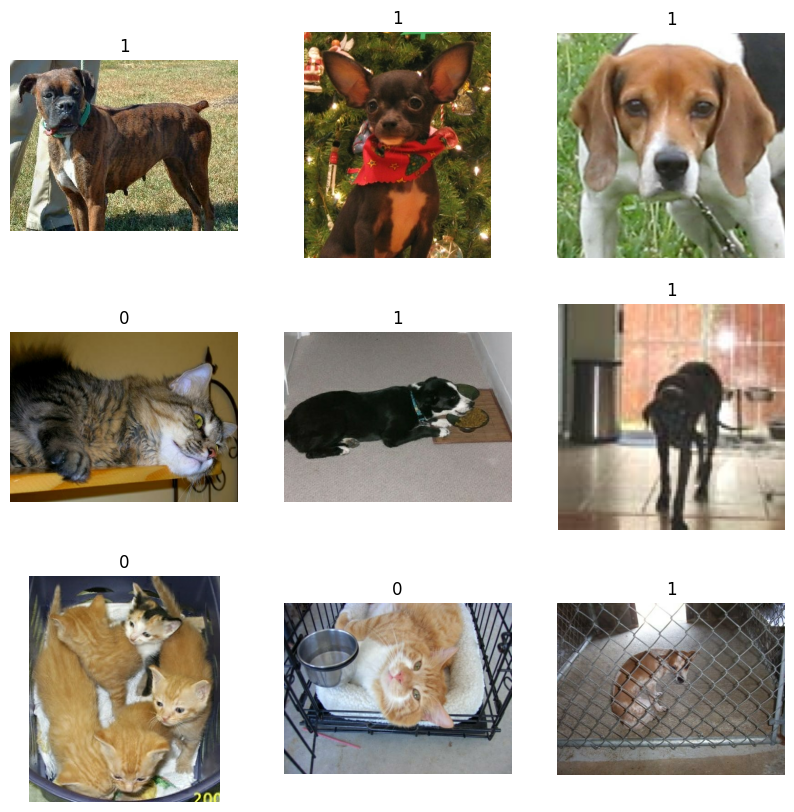

In [11]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Estandarització de les dades

Ara anem a estandarditzar les imatges. Aplicarem un resize a 150x150 a tot el conjunt del dataset.

In [12]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### Aplican DA

Farem random data augmentation aplicant una rotació aleatoria

In [13]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Les segúents linees incrementaran la nostre velocitat de carrega de les imatges per l'entrenament

In [14]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

Mostrarem ara denou les imatges

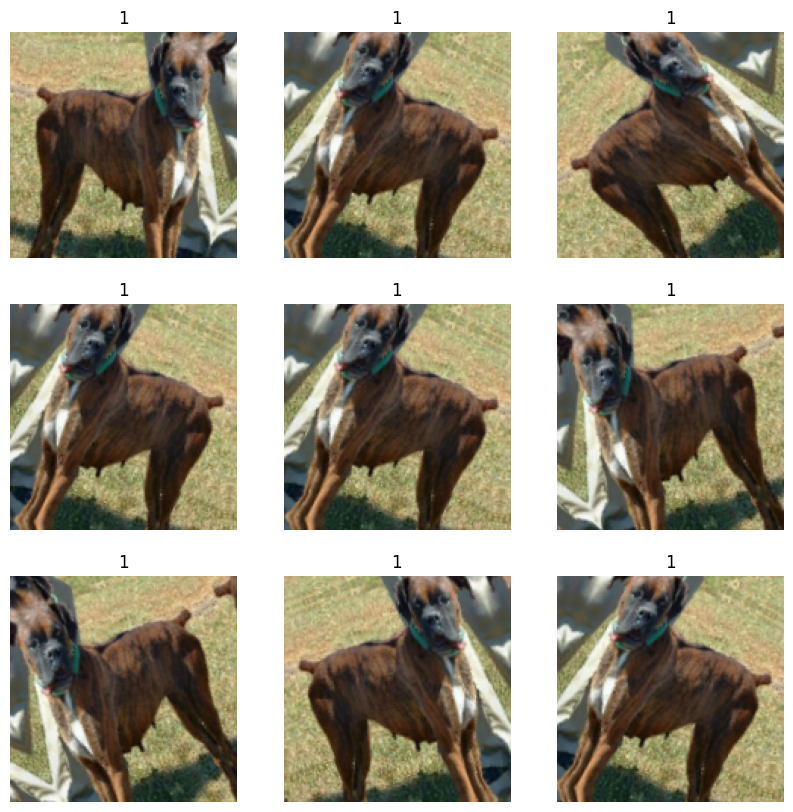

In [15]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Construint el model

Anem a definir ara novament el nostre model.

In [16]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

# congelem les capes
base_model.trainable = False

# Creem el nou top del model
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout (Dropout)           (None, 2048)              0   

### Entrenant el model

Ara podrem observar com un model pesat pot ser entrenat i adaptat a un nou conjunt amb uns petits canvis.

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 84s 493ms/step - loss: 0.1876 - binary_accuracy: 0.9177 - val_loss: 0.0892 - val_binary_accuracy: 0.9699
Epoch 2/2
146/146 [==============================] - 24s 163ms/step - loss: 0.1198 - binary_accuracy: 0.9506 - val_loss: 0.0807 - val_binary_accuracy: 0.9682


Finalment descongelem i acabem de fer el fine-tunning

In [18]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout (Dropout)           (None, 2048)              0   

Per acabar evaluem el model

In [19]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 5s 124ms/step - loss: 0.0673 - binary_accuracy: 0.9738


[0.06730467826128006, 0.9737747311592102]

## Exercici

Agafeu un dataset de la vostra elecció (ha de ser de classificació d'imatges) i apliqueu novament els passos seguits però ara amb VGG16.

Haureu de pujar i adjuntar aquest mateix notebook al classrom.

**Data d'entrega**: 5/6/2024